你已经学习了如何加载和表示2D图像，比如使用相机拍摄的图像。在诸如涉及CT（Computed Tomography）扫描等医学成像应用程序的情况下，通常需要处理从头到脚方向堆叠的图像序列，每个序列对应于整个身体的横截面。在CT扫描中，强度代表身体不同部位的密度：肺、脂肪、水、肌肉、骨骼，以密度递增的顺序排列，当在临床工作站上显示CT扫描时，会从暗到亮映射。根据穿过人体后到达检测器的X射线量计算每个点的密度，并使用一些复杂的数学运算将原始传感器数据反卷积（deconvolve）为完整体积数据。


CT具有单个的强度通道，这类似于灰度图像。通常在本地数据格式中，通道维度被忽略了，因此原始数据通常会具有三个维度。通过将单个2D切片堆叠到3D张量中，你可以构建表示对象的3D解剖结构的体积数据。与图3.3不同，图3.4中的额外的维表示物理空间中的偏移量，而不是可见光谱的特定频带。

从头顶到颌骨的CT扫描切片
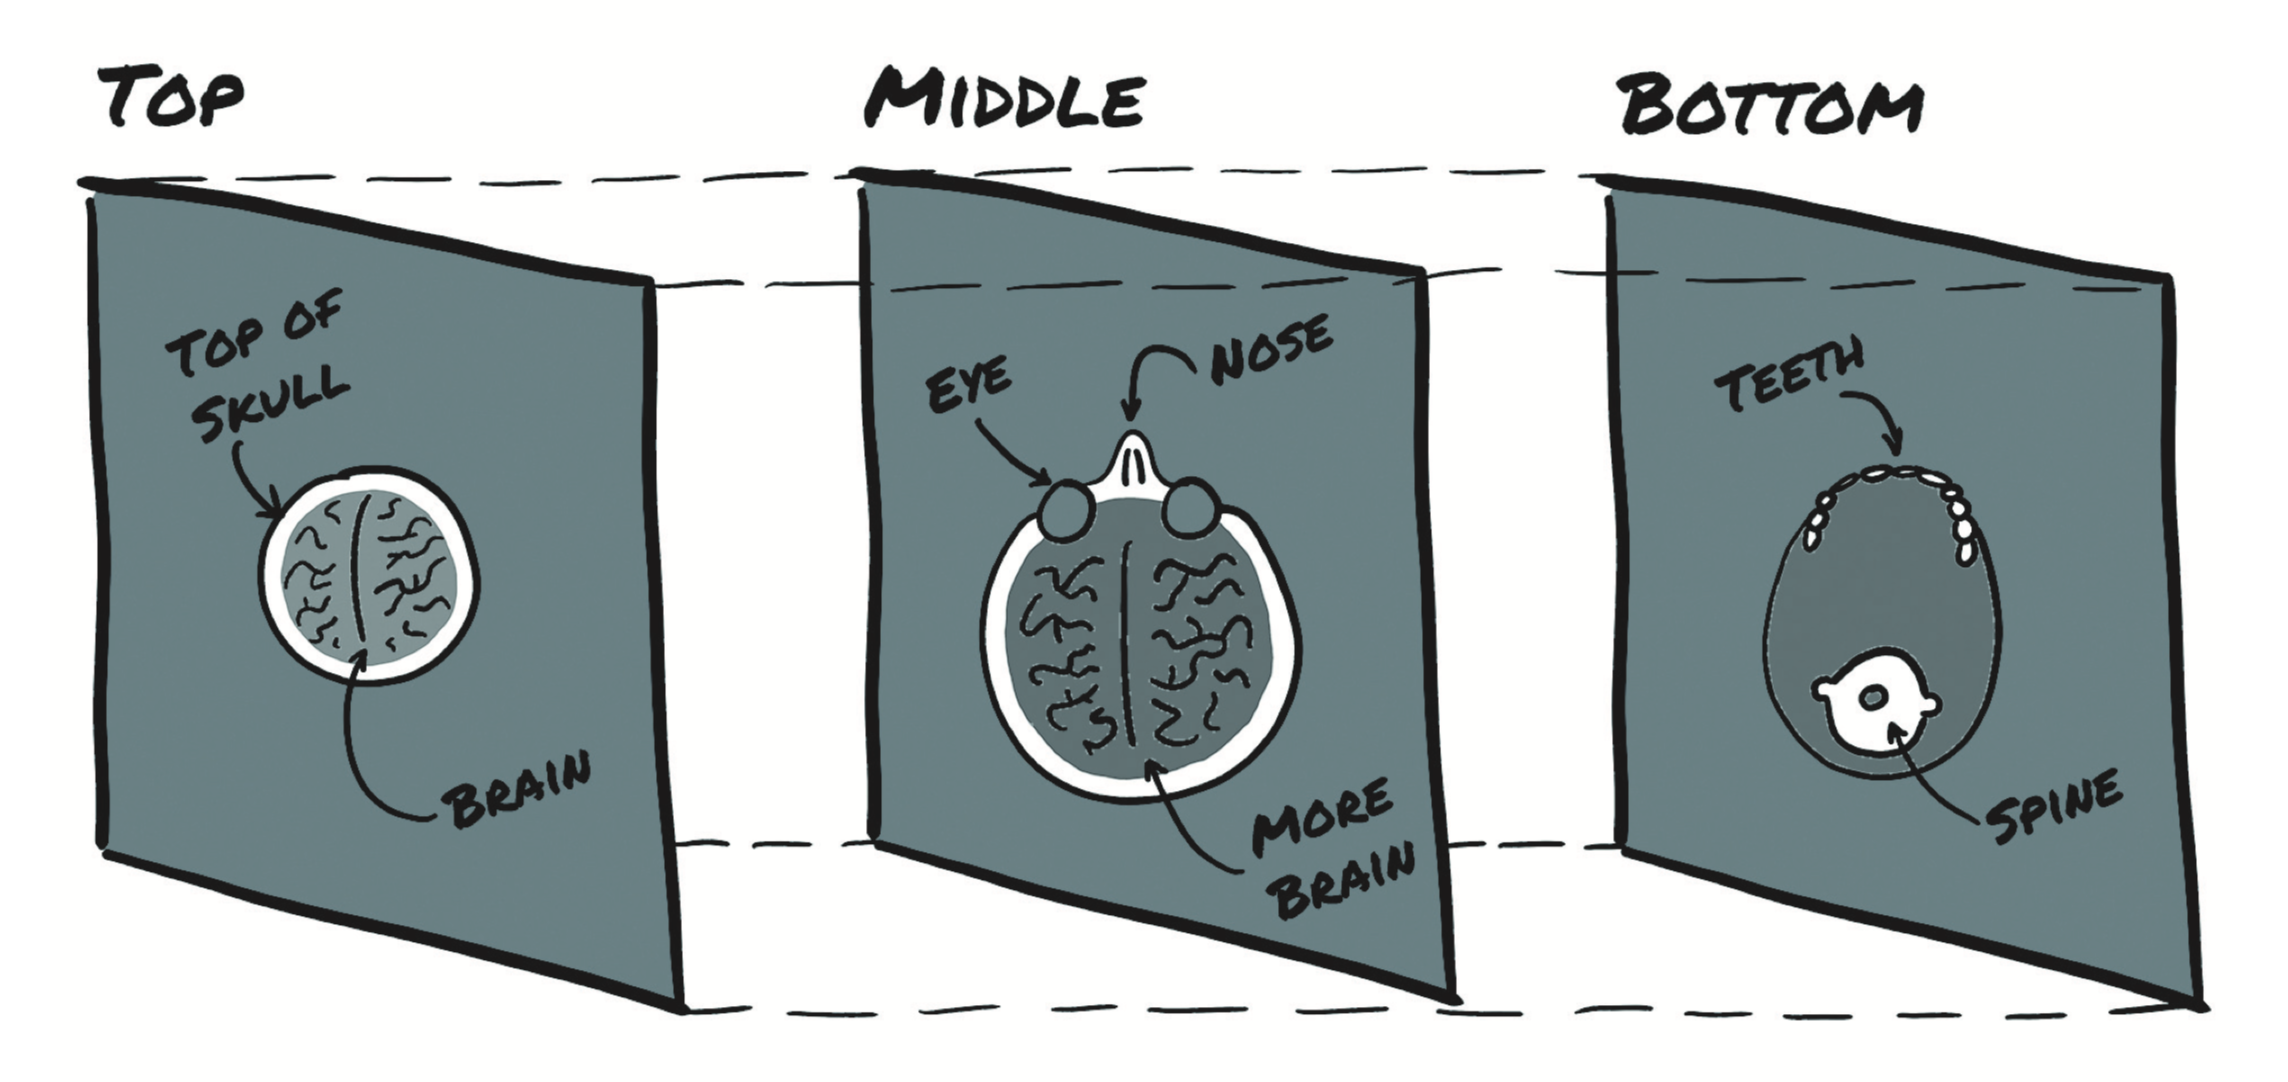

存储体积数据的张量和存储图像数据的张量之间不存在根本差异。在通道（channel）维之后，你有一个额外的维——深度（depth），**形成5D张量为N x C x D x H x W**。

---

### 1 加载CT扫描样本

使用**imageio模块中的volread函数**加载一个CT扫描样本，该函数以文件夹作为参数，将所有DICOM（Digital Imaging Communication and Storage，数字图像通信和存储）系列文件组合成一个NumPy 3D数组中

volumetric 测定体积的

In [13]:
import imageio

In [14]:
dir_path = r"./data/chapter3/volumetric-dicom/2-LUNG 3.0  B70f-04083/"
vol_arr = imageio.volread(dir_path,format='DICOM') 
    # DICOM（Digital Imaging and Communications in Medicine）即医学数字成像和通信

vol_arr.shape

Reading DICOM (examining files): 1/99 files (1.0%93/99 files (93.9%99/99 files (100.0%)
  Found 1 correct series.
Reading DICOM (loading data): 45/99  (45.596/99  (97.099/99  (100.0%)


(99, 512, 512)

### 2 由于缺少通道信息，此时的维度设置与PyTorch所期望的不同。你必须通过unsqueeze为新增通道（channel）维——depth

**目标形成4D张量为C x D x H x W**

In [15]:
import torch

In [16]:
# 目前输入张量 W x H x C
vol = torch.from_numpy(vol_arr).float()
# 转置为 CxHxW
vol = torch.transpose(vol,dim0=0,dim1=2)
# 在C维度之后增加一个维度depth
vol = torch.unsqueeze(vol,dim=1)

vol.shape

torch.Size([512, 1, 512, 99])

### 3 沿着批处理batch方向堆叠多个体积数据组装为 5D数据集 NxCxDxHxW

In [17]:
batch_size = 10 # 后续读取的文件数不应该大于这个数目。
n_cannels = 512
depth = 1
H = 512
W = 99
batch = torch.zeros(batch_size,n_cannels,depth,H,W).float()

In [18]:
import os

In [19]:
filenames = [ name for name in os.listdir(dir_path) if os.path.splitext(name)[-1]=='.dcm']
# 文件数不应该大于batch_size
filenames = filenames[:batch_size] 

In [20]:
for i,filename in enumerate(filenames):
    vol_arr = imageio.volread(dir_path+filename)
    # W H C
    vol = torch.from_numpy(vol_arr)
    # C H W
    vol = torch.transpose(vol,dim0=0,dim1=2)
    # 在C维度后增加depth维度 C D H W
    vol = torch.unsqueeze(vol,dim=1)
    # 加入batch ,batch-5D：N C D H W
    batch[i] = vol

Reading DICOM (examining files): 1/99 files (1.0%99/99 files (100.0%)
  Found 1 correct series.
Reading DICOM (loading data): 54/99  (54.599/99  (100.0%)
Reading DICOM (examining files): 1/99 files (1.0%99/99 files (100.0%)
  Found 1 correct series.
Reading DICOM (loading data): 48/99  (48.596/99  (97.099/99  (100.0%)
Reading DICOM (examining files): 1/99 files (1.0%99/99 files (100.0%)
  Found 1 correct series.
Reading DICOM (loading data): 47/99  (47.599/99  (100.0%)
Reading DICOM (examining files): 1/99 files (1.0%83/99 files (83.8%99/99 files (100.0%)
  Found 1 correct series.
Reading DICOM (loading data): 50/99  (50.592/99  (92.999/99  (100.0%)
Reading DICOM (examining files): 1/99 files (1.0%99/99 files (100.0%)
  Found 1 correct series.
Reading DICOM (loading data): 51/99  (51.599/99  (100.0%)
Reading DICOM (examining files): 1/99 files (1.0%99/99 files (100.0%)
  Found 1 correct series.
Reading DICOM (loading data): 51/99  (51.591/99  (91.999/99  (100.0%)
Reading DICOM (examini

### 4 将张量转换为浮点数并归一化像素值

计算输入数据的均值和标准偏差并对其进行缩放，以便于在**每个通道**上的均值和单位标准偏差输出为零

In [25]:
batch = batch.float()
n_cannels = batch.shape[1] # NCDHW
for c in range(n_cannels):
    mean = torch.mean(batch[:,c])
    std = torch.std(batch[:,c])
    batch[:,c] = (batch[:,c]-mean)/std

---

# 总结
- 神经网络要求将数据表示为多维数值张量，通常为32位浮点数。
- 多亏了PyTorch库可以与Python标准库和周围的生态系统进行交互，因此可以方便地加载最常见的数据类型并将其转换为PyTorch张量。
- 通常，PyTorch期望沿特定维度布局数据，这取决于模型架构（例如卷积与递归）。使用PyTorch张量API可以有效地实现数据重塑。
- 电子表格可以很容易地直接转换为张量。类别和序数值列的处理方式应与区间值列的处理方式有所不同。
- 通过使用字典，文本或分类数据可以使用独热编码表示。
- 图像可以具有一个或多个通道。最常见的是典型数码照片的红色、绿色和蓝色通道。
- 单通道数据格式有时会忽略显式的通道维。
- 体积数据类似于2D图像数据，但增加了第三维：深度。
- 尽管12位和16位图像并不罕见，但是大多数图像每像素依然还是8位。这些图像可以存储为32位浮点数，并不会降低精度。